# 2D Navier-Stokes - Channel Flow

This tutorial comes from the following resources:

* 12 Steps to Navier-Stokes
    * 2D NavierStokes (Cavity Flow) -[ipynb](https://nbviewer.org/github/barbagroup/CFDPython/blob/master/lessons/14_Step_11.ipynb)

In [1]:
import diffrax as dfx
import equinox as eqx
import finitediffx as fdx
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import xarray as xr
from jaxtyping import Array
from matplotlib import cm

from jaxsw._src.domain.base import Domain
from jaxsw._src.domain.time import TimeDomain
from jaxsw._src.models.pde import DynamicalSystem


sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)
jax.config.update("jax_enable_x64", True)

%matplotlib inline
%load_ext autoreload
%autoreload 2

Let's start with a simple 2D Diffusion scheme. This PDE is defined as:

$$
\begin{aligned}
\frac{\partial u}{\partial t} &+ 
u\frac{\partial u}{\partial x} + v\frac{\partial u}{\partial y} = 
- \frac{1}{\rho}\frac{\partial p}{\partial x} +
\nu\left(\frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2}\right) \\
\frac{\partial v}{\partial t} &+ 
u\frac{\partial v}{\partial x} + v\frac{\partial v}{\partial y} = 
- \frac{1}{\rho}\frac{\partial p}{\partial y} +
\nu\left(\frac{\partial^2 v}{\partial x^2} + \frac{\partial^2 v}{\partial y^2} \right) \\
\frac{\partial^2 p}{\partial x^2} &+ \frac{\partial^2 p}{\partial y^2}  =
-\rho\left( \frac{\partial u}{\partial x}\frac{\partial u}{\partial x} +
2 \frac{\partial u}{\partial y}\frac{\partial v}{\partial x} +
\frac{\partial v}{\partial y}\frac{\partial v}{\partial y}\right)
\end{aligned}
$$ (eq:2d_ns)

where $\nu$ is the diffusivity. Here, we are advised to:
* Diffusion Term - 2nd order accurate central difference scheme
* Advection Term - 1st order accuracy backwards difference scheme
* Time Step - 1st order temporal scheme (Euler).
* Initialization - same hat
* Boundaries - 1's everywhere

## Domain

In [2]:
nx, ny = 81, 81
xmin, ymin = 0.0, 0.0
xmax, ymax = 2.0, 2.0

In [3]:
domain = Domain.from_numpoints(xmin=(xmin, ymin), xmax=(xmax, ymax), N=(nx, ny))

print(f"Size: {domain.size}")
print(f"nDims: {domain.ndim}")
print(f"Grid Size: {domain.grid.shape}")
print(f"Cell Volume: {domain.cell_volume}")

Size: (80, 80)
nDims: 2
Grid Size: (80, 80, 2)
Cell Volume: 0.0006250000000000001


### State

So we have 3 variables, $u,v,p$. We will use the nifty state container that we did for the Burger's example.

We also have 2 constants that we need to keep track of, $\rho,\nu$.

In [4]:
from typing import Callable, NamedTuple


class Params(NamedTuple):
    domain: Domain
    nu: float
    rho: float


class State(NamedTuple):
    u: Array
    v: Array
    p: Array

    @classmethod
    def init_state(cls, domain: Domain, init_fn: Callable):
        u = init_fn(domain)
        v = init_fn(domain)
        p = init_fn(domain)

        return cls(u=u, v=v, p=p)

    def to_xarray(self, params, ts):
        return None

### Initial Conditions

We're doing the same hat initialization as before.

$$
\begin{aligned}
\mathcal{IC}[u,v,p](\mathbf{x}) &= 0, && && \mathbf{x}\in(\Omega,\partial\Omega)
\end{aligned}
$$

In [5]:
def init_u0(domain):
    """Initial condition from grid"""
    u = jnp.zeros(domain.size, dtype=jnp.float64)

    return u

#### Demo Plot

In [6]:
# initialize state
state_init = State.init_state(domain, init_fn=init_u0)

# initialize parameters
nu = 0.1
rho = 1.0

params = Params(domain=domain, nu=nu, rho=rho)


# update state (manually)
state_update = State(u=state_init.u, v=state_init.v, p=state_init.p)

# update state (convenience function)
state_update_ = eqx.tree_at(lambda x: x.u, state_init, state_init.u)

assert state_update == state_update_

In [7]:
from matplotlib import cm


def plot_state_3D(state, params, axis=None):
    fig, ax = plt.subplots(ncols=3, figsize=(15, 5), subplot_kw={"projection": "3d"})

    surf = ax[0].plot_surface(
        params.domain.grid[..., 0],
        params.domain.grid[..., 1],
        state.u[axis] if axis is not None else state.u,
        cmap=cm.viridis,
    )

    plt.colorbar(surf, shrink=0.4, aspect=12)
    ax[0].set(title="u-velocity")

    surf = ax[1].plot_surface(
        params.domain.grid[..., 0],
        params.domain.grid[..., 1],
        state.v[axis] if axis is not None else state.v,
        cmap=cm.viridis,
    )
    plt.colorbar(surf, shrink=0.4, aspect=12)
    ax[1].set(title="v-velocity")

    # Pressure
    surf = ax[2].plot_surface(
        params.domain.grid[..., 0],
        params.domain.grid[..., 1],
        state.p[axis] if axis is not None else state.p,
        cmap=cm.viridis,
    )
    ax[2].set(title="Pressure")
    plt.colorbar(surf, shrink=0.4, aspect=12)
    plt.tight_layout()
    plt.show()


def plot_state_2D(state, params, axis=None):
    fig, ax = plt.subplots(ncols=3, figsize=(15, 5))

    surf = ax[0].pcolormesh(
        params.domain.grid[..., 0],
        params.domain.grid[..., 1],
        state.u[axis] if axis is not None else state.u,
        cmap=cm.viridis,
    )

    plt.colorbar(surf, shrink=0.4, aspect=12)
    ax[0].set(title="u-velocity")

    surf = ax[1].pcolormesh(
        params.domain.grid[..., 0],
        params.domain.grid[..., 1],
        state.v[axis] if axis is not None else state.v,
        cmap=cm.viridis,
    )
    plt.colorbar(surf, shrink=0.4, aspect=12)
    ax[1].set(title="v-velocity")

    # Pressure
    surf = ax[2].pcolormesh(
        params.domain.grid[..., 0],
        params.domain.grid[..., 1],
        state.p[axis] if axis is not None else state.p,
        cmap=cm.viridis,
    )
    ax[2].set(title="Pressure")
    plt.colorbar(surf, shrink=0.4, aspect=12)
    plt.tight_layout()
    plt.show()


def plot_vectorfield_2D(state, params, axis=None):
    fig, ax = plt.subplots(figsize=(5, 4))
    # pressure field as contour
    pts = ax.contourf(
        params.domain.grid[..., 0],
        params.domain.grid[..., 1],
        state.p[axis] if axis is not None else state.p,
        alpha=0.5,
        cmap=cm.viridis,
    )
    # pressure field outlines
    ax.contour(
        params.domain.grid[..., 0],
        params.domain.grid[..., 1],
        state.p[axis] if axis is not None else state.p,
        alpha=0.5,
        cmap=cm.viridis,
    )
    # velocity field
    ax.quiver(
        params.domain.grid[..., 0],
        params.domain.grid[..., 1],
        state.u[axis] if axis is not None else state.v,
        state.v[axis] if axis is not None else state.v,
    )
    plt.colorbar(pts)
    plt.tight_layout()
    plt.show()

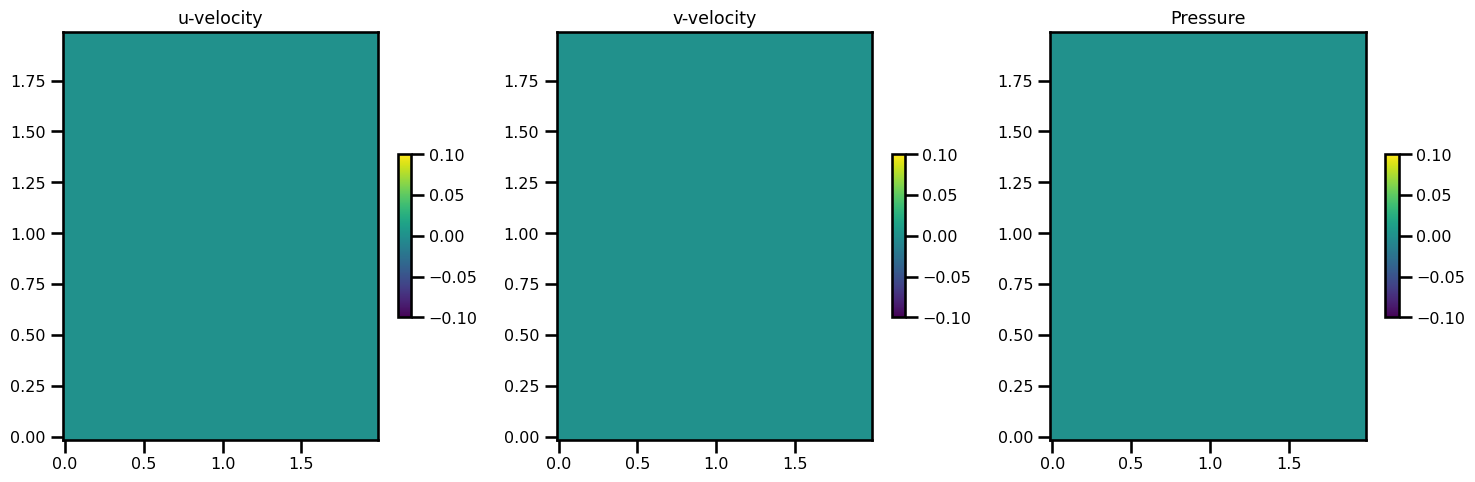

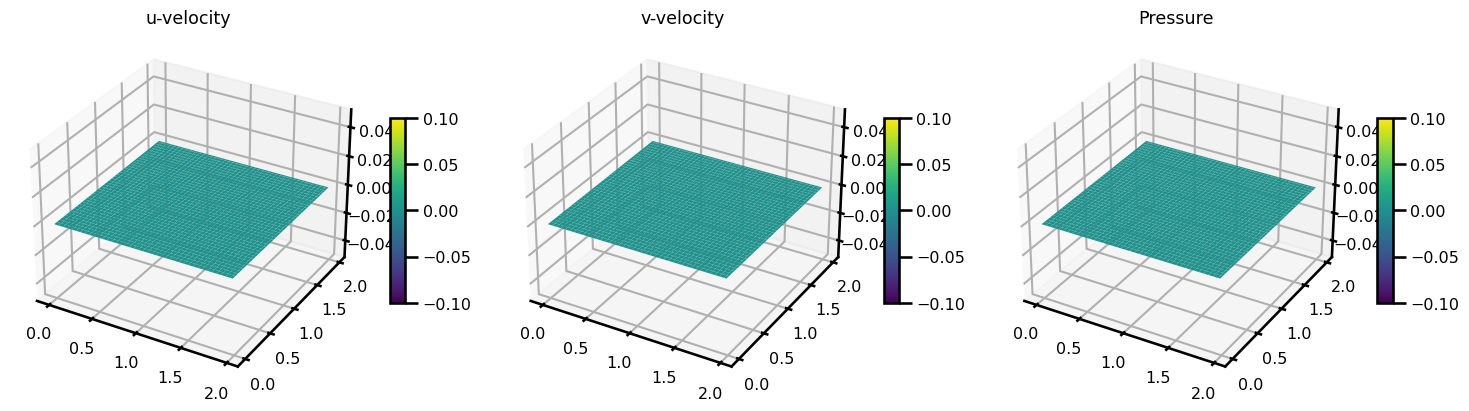

/Users/eman/miniconda3/envs/jaxsw/lib/python3.11/site-packages/matplotlib/quiver.py:646: RuntimeWarning: divide by zero encountered in scalar divide
  length = a * (widthu_per_lenu / (self.scale * self.width))
/Users/eman/miniconda3/envs/jaxsw/lib/python3.11/site-packages/matplotlib/quiver.py:646: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


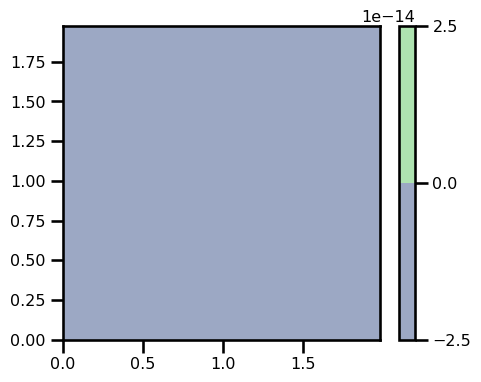

In [8]:
plot_state_2D(state_init, params)
plot_state_3D(state_init, params)
plot_vectorfield_2D(state_init, params)

### Boundary Conditions

We have some fancy boundary conditions because they depend upon the variable we are interested in.

**U-Velocities**

$$
\begin{aligned}
\mathcal{BC}[u](x,y) &= 
\begin{cases}
1 && && (y=L_y)\in\partial\Omega_y \\
0 && && (x,y) \in \partial\Omega
\end{cases}
\end{aligned}
$$


Note, we use the same BCs for both $u$ and $v$.

In [9]:
def boundaries_u(u: Array) -> Array:
    u = u.at[0, :].set(0.0)  # u(0,:) = 0
    u = u.at[-1, :].set(0.0)  # u(Lx,:) = 0
    u = u.at[:, 0].set(0.0)  # u(:,0) = 0
    u = u.at[:, -1].set(1.0)  # u(:,Ly) = 1 (cavity lid)
    return u

**V-Velocities**

$$
\begin{aligned}
\mathcal{BC}[v](x,y) &= 0 && && (x,y) \in \partial\Omega
\end{aligned}
$$





In [10]:
def boundaries_v(v: Array) -> Array:
    v = v.at[0, :].set(0.0)  # v(0,:)  = 0
    v = v.at[-1, :].set(0.0)  # v(Lx,:) = 0
    v = v.at[:, 0].set(0.0)  # v(:,0) = 0
    v = v.at[:, -1].set(0.0)  # v(:,Ly) = 0
    return v


**Pressure**. This is easily the most complicated BCs we have. They involve Dirichlet and Neumann.

$$
\begin{aligned}
\mathcal{BC}\left[\frac{\partial p}{\partial y} \right](x,y) &= 0 && && (x,y=0)\in\partial\Omega \\
\mathcal{BC}\left[p \right](x,y) &= 0 && && (y=L_y)\in\partial\Omega_y \\
\end{aligned}
$$

In [11]:
def boundaries_p(p: Array) -> Array:
    p = p.at[0, :].set(p[1, :])  # dp/dx = 0 @ x = 0
    p = p.at[-1, :].set(p[-2, :])  # dp/dx = 0 @ x = Lx
    # cavity entrance
    p = p.at[:, 0].set(p[:, 1])  # dp/dy = 0 @ y = 0
    # cavity lid (exit)
    p = p.at[:, -1].set(0.0)  # p = 0 @ y = Ly
    return p

In [12]:
u_bc = boundaries_u(state_init.u)
v_bc = boundaries_v(state_init.v)
p_bc = boundaries_p(state_init.p)

state_rhs = eqx.tree_at(lambda x: x.p, state_init, p_bc)
state_rhs = eqx.tree_at(lambda x: x.u, state_rhs, u_bc)
state_rhs = eqx.tree_at(lambda x: x.v, state_rhs, v_bc)

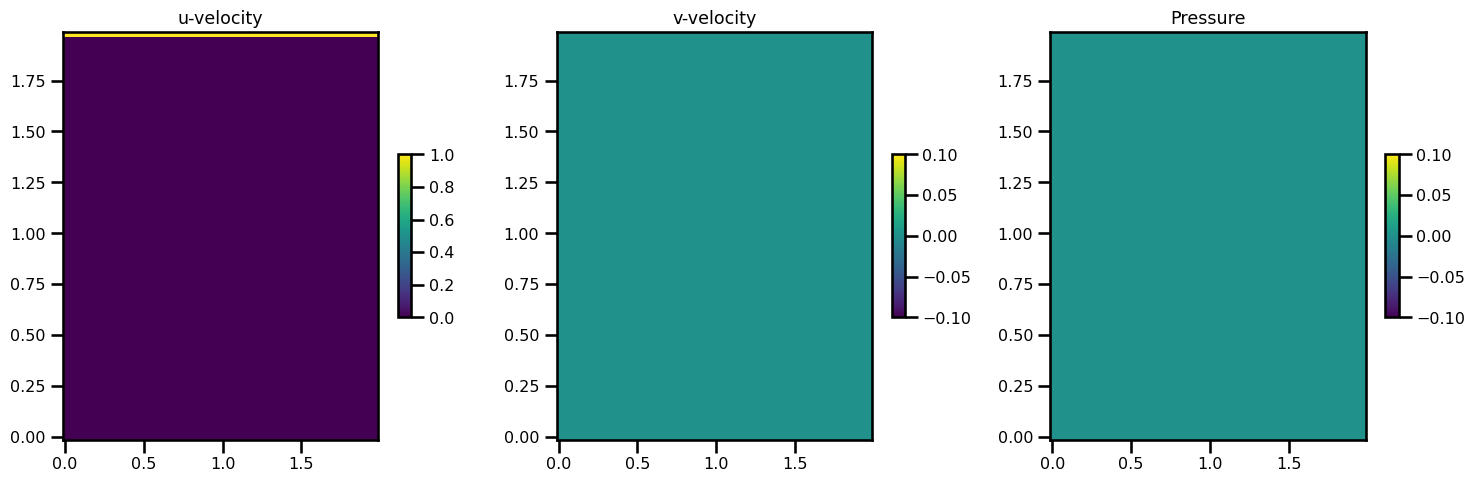

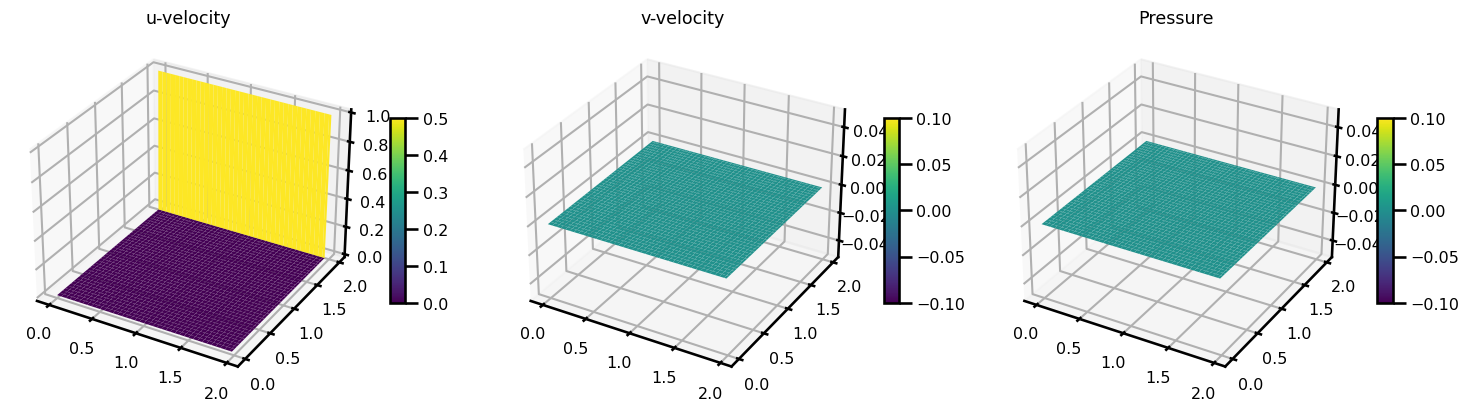

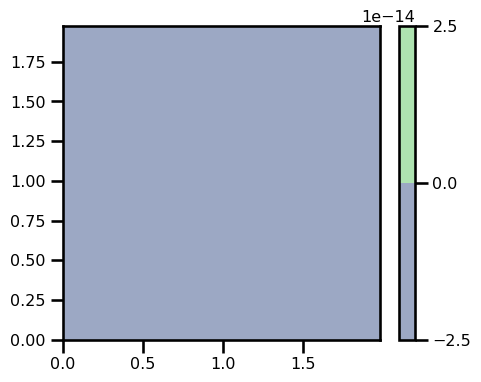

In [13]:
plot_state_2D(state_rhs, params)
plot_state_3D(state_rhs, params)
plot_vectorfield_2D(state_rhs, params)

## Equation of Motion

Now we need to create the equation of motion for the NS equation {eq}`eq:2d_ns`. However, there are many overlapping components. So we need to be a bit strategic when defining the functions. My personal strategy is the following:



**PDE Type**. I create generic PDEs for the advection, diffusion, and inversion terms. These should be generic functions because we may need to reuse these in later equations. 

**State Element**. I create the functions for each of the state variables ($u,v,p$). These are normally some combination of advection, diffusion, and inversion so hopefully I can reuse some of the above generic functions.

**Forcings**. These tend to be the tailored/handcrafted equations but often the most important. So I save these for last because this would often require the most individual tweaking compared to the main scheme.

$$
\begin{aligned}
p &= \boldsymbol{f_p}(u,v,\theta) \\
\frac{\partial u}{\partial t} &= \boldsymbol{f_u}(u,v,p,\theta) \\
\frac{\partial v}{\partial t} &= \boldsymbol{f_v}(u,v,p,\theta)
\end{aligned}
$$ (eq:2d_ns)

### Sub PDEs

* Linear
* Advection
* Diffusion
* Elliptical

In [14]:
"""Generic 2D Diffusion Term
Advection:
    ∂u/∂t = a ∂u/∂x + b ∂u/∂y

Diffusion:
    ∂u/∂t = ν (∂²u/∂x² + ∂²u/∂y²)
   x
\nVelocity Product:
    ∂u/∂t =  -ρ(∂u/∂x ∂u/∂x + ∂u/∂y ∂v/∂x + ∂v/∂y ∂v/∂y)
    
Inversion Term:
    Ax = b
    Δu = f

"""

'Generic 2D Diffusion Term\nAdvection:\n    ∂u/∂t = a ∂u/∂x + b ∂u/∂y\n\nDiffusion:\n    ∂u/∂t = ν (∂²u/∂x² + ∂²u/∂y²)\n   x\n\nVelocity Product:\n    ∂u/∂t =  -ρ(∂u/∂x ∂u/∂x + ∂u/∂y ∂v/∂x + ∂v/∂y ∂v/∂y)\n    \nInversion Term:\n    Ax = b\n    Δu = f\n\n'

### Pressure Term

$$
\begin{aligned}
\frac{\partial^2 p}{\partial x^2} &+ \frac{\partial^2 p}{\partial y^2}  =
-\rho\left( \frac{\partial u}{\partial x}\frac{\partial u}{\partial x} +
2 \frac{\partial u}{\partial y}\frac{\partial v}{\partial x} +
\frac{\partial v}{\partial y}\frac{\partial v}{\partial y}\right)
\end{aligned}
$$ (eq:2d_ns_p)

Looking at the NS equation {eq}`eq:2d_ns`, we have this sort of combinatorial reduction productn for the pressure term. It's defined as

$$
\begin{aligned}
\frac{\partial p}{\partial t} &= 
-\rho \left( \frac{\partial u}{\partial x}\frac{\partial u}{\partial x} +
2 \frac{\partial u}{\partial y}\frac{\partial v}{\partial x} +
\frac{\partial v}{\partial y}\frac{\partial v}{\partial y}\right)
\end{aligned}
$$

I don't have any recommendations for the type of scheme that we need for this... In any case, we can define a generic function for this:

$$
\text{VelocityProd} :=  -\rho \left( \frac{\partial u(x,t)}{\partial x}\frac{\partial u(x,y)}{\partial x} +
2 \frac{\partial u(x,y)}{\partial y}\frac{\partial v(x,y)}{\partial x} +
\frac{\partial v(x,y)}{\partial y}\frac{\partial v(x,y)}{\partial y}\right)
$$



The only tricky thing about this is that we actually have an inversion problem.

$$
\begin{aligned}
\nabla^2 p &= f(x,y) \\
\mathbf{L}p &= \mathbf{F}\\
\end{aligned}
$$

In [15]:
import functools as ft

from jaxopt import linear_solve

from jaxsw._src.operators.functional import elliptical
from jaxsw._src.utils.linear_solver import (
    jaxopt_linear_solver,
)


def p_term(state, params, **kwargs) -> Array:
    """Generic 2D Diffusion Term

    Equation:
        -ρ ( ∂u/∂x ∂u/∂x + ∂u/∂y ∂v/∂x + ∂v/∂y ∂v/∂y )

    """

    # parse state
    u, v, p = state.u, state.v, state.p

    # parse parameters
    domain, rho = params.domain, params.rho

    # calculate boundaries
    # u = boundaries_u(u)
    # v = boundaries_v(v)
    # p = boundaries_p(p)

    # calculate velprod term
    du_dx = fdx.difference(
        u,
        axis=0,
        step_size=domain.dx[0],
        derivative=1,
        method="central",
        **kwargs,
    )
    du_dy = fdx.difference(
        u,
        axis=1,
        step_size=domain.dx[1],
        derivative=1,
        method="central",
        **kwargs,
    )
    dv_dx = fdx.difference(
        v,
        axis=0,
        step_size=domain.dx[0],
        derivative=1,
        method="central",
        **kwargs,
    )
    dv_dy = fdx.difference(
        v,
        axis=1,
        step_size=domain.dx[1],
        derivative=1,
        method="central",
        **kwargs,
    )

    b = -rho * (du_dx**2 + 2 * du_dy * dv_dx + dv_dy**2)

    # # define matvec function
    # matvec_fn = ft.partial(elliptical.laplacian_matvec, step_size=domain.dx, bc_fn=boundaries_p)

    # # get solution
    # target_criterion = 1e-6
    # max_iterations = 100_000
    # criterion = "l2"

    # out = steepest_descent(
    #     b=b,
    #     matvec_fn=matvec_fn,
    #     u_init=p,
    #     target_criterion=target_criterion,
    #     max_iterations=max_iterations,
    #     criterion=criterion,
    # )

    # p = out.u

    # p = jnp.where(jnp.isnan(p), 0.0, p)

    # return p

    # define matvec function
    matvec_fn = ft.partial(
        elliptical.laplacian_matvec, step_size=domain.dx, bc_fn=boundaries_p
    )

    # define solver
    solver = linear_solve.solve_cg  # BiCGStab, NormalCG, GMRES, CG
    solver_kwargs = dict(maxiter=100_000, tol=1e-6)
    # get solution
    p = jaxopt_linear_solver(
        matvec_fn=matvec_fn, b=b, x0=None, solver=solver, **solver_kwargs
    )

    # p = jnp.where(jnp.isnan(p), 0.0, p)

    return p

    # # define matvec function
    # matvec_fn = ft.partial(elliptical.laplacian_matvec, step_size=domain.dx, bc_fn=boundaries_p)

    # # define solver
    # solver = lx.GMRES(rtol=1e-5, atol=1e-5)  # BiCGStab, NormalCG, GMRES, CG
    # # solver = lx.AutoLinearSolver(well_posed=False)

    # # get solution
    # p_rhs = lx_linear_solver(matvec_fn, b, solver=solver, verbose=True)

    # return p_rhs

In [16]:
from jaxsw._src.operators.functional import advection


# calculate P
p_rhs = p_term(state_init, params)
state_rhs = eqx.tree_at(lambda x: x.p, state_init, p_rhs)

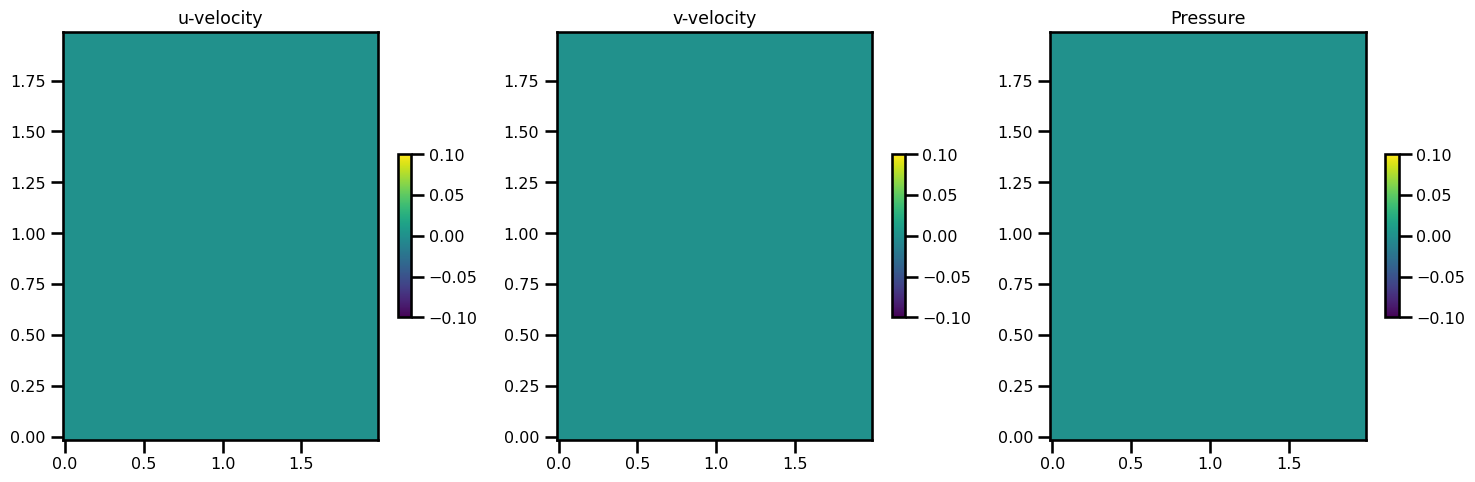

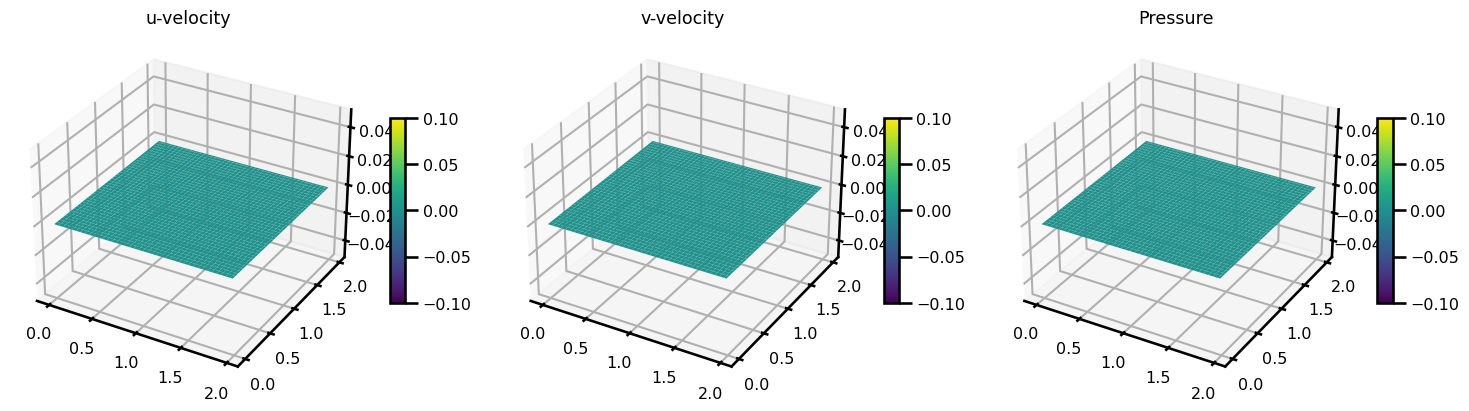

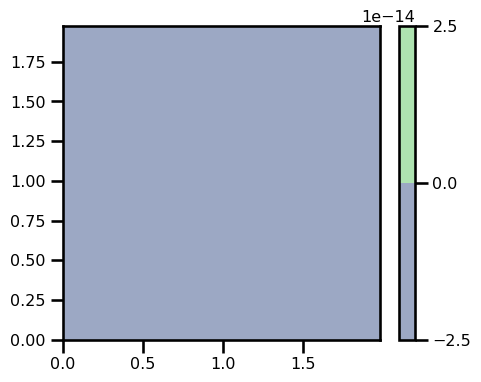

In [17]:
plot_state_2D(state_rhs, params)
plot_state_3D(state_rhs, params)
plot_vectorfield_2D(state_rhs, params)

#### Advection Term

We have the advection term for both $u$ and $v$:

$$
\begin{aligned}
\frac{\partial u}{\partial t} &+ 
u\frac{\partial u}{\partial x} + v\frac{\partial u}{\partial y} = 0 \\
\frac{\partial v}{\partial t} &+ 
u\frac{\partial v}{\partial x} + v\frac{\partial v}{\partial y} = 0
\end{aligned}
$$

They recommend that we use the 1st order accurate backward difference scheme. We will make a generic advection function term that should work for both $u$ and $v$.

We can generically write this as:

$$
\text{Advection} :=  a(x,y)\frac{\partial u(x,t)}{\partial x} + b(x,y)\frac{\partial u(x,t)}{\partial y}
$$

In [18]:
from jaxsw._src.operators.functional import advection


def u_term(state, params):
    # parse state
    u, v = state.u, state.v

    # parse parameters
    domain = params.domain

    # # calculate boundaries
    # u = boundaries_u(u)
    # v = boundaries_v(v)

    # calculate advection term
    u_rhs_advection = advection.advection_2D(
        u=state_rhs.u,
        a=state_rhs.u,
        b=state_rhs.v,
        step_size=domain.dx,
        accuracy=1,
    )

    # calculate RHS
    u_rhs = -u_rhs_advection
    return u_rhs


def v_term(state, params):
    # parse state
    u, v = state.u, state.v

    # parse parameters
    domain = params.domain

    # # calculate boundaries
    # u = boundaries_u(u)
    # v = boundaries_v(v)

    # calculate advection term
    v_rhs_advection = advection.advection_2D(
        u=state_rhs.v,
        a=state_rhs.u,
        b=state_rhs.v,
        step_size=domain.dx,
        accuracy=1,
    )

    # calculate RHS
    v_rhs = -v_rhs_advection
    return v_rhs

In [19]:
from jaxsw._src.operators.functional import advection


# calculate P
p = p_term(state_init, params)
state_rhs = eqx.tree_at(lambda x: x.p, state_init, p)

# calculate RHS - U,V
u_rhs = u_term(state_rhs, params)
v_rhs = v_term(state_rhs, params)

# some checks
assert u_rhs.shape == state_init.u.shape == v_rhs.shape == state_init.v.shape
print(u_rhs.min(), u_rhs.max())

# update state
state_rhs = eqx.tree_at(lambda x: x.u, state_rhs, u_rhs)
state_rhs = eqx.tree_at(lambda x: x.v, state_rhs, v_rhs)

-0.0 -0.0


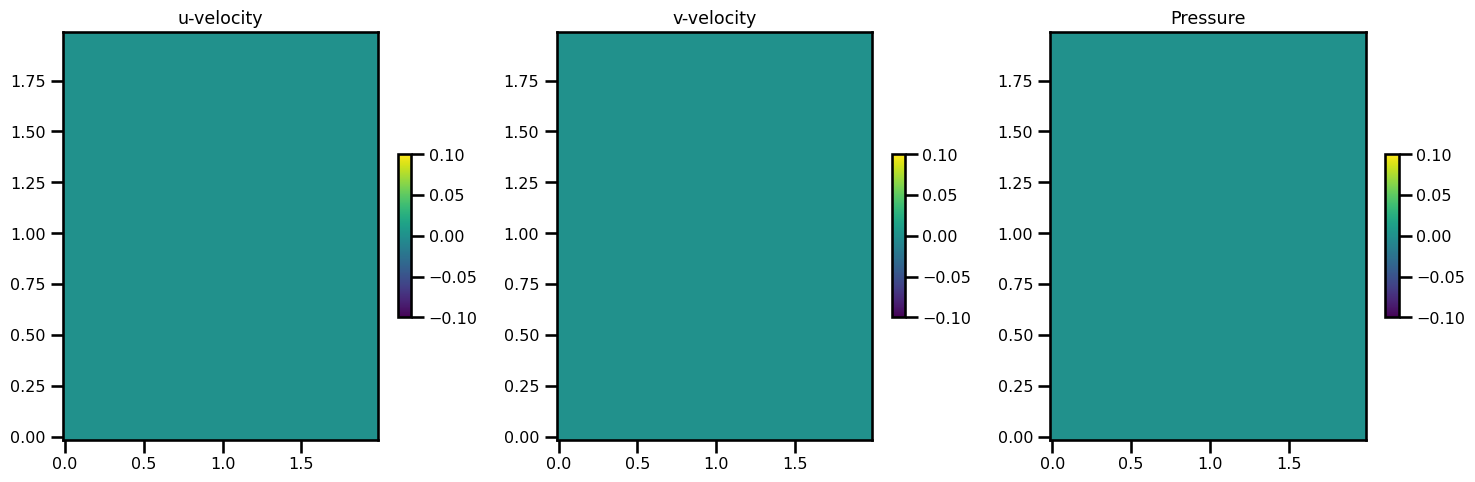

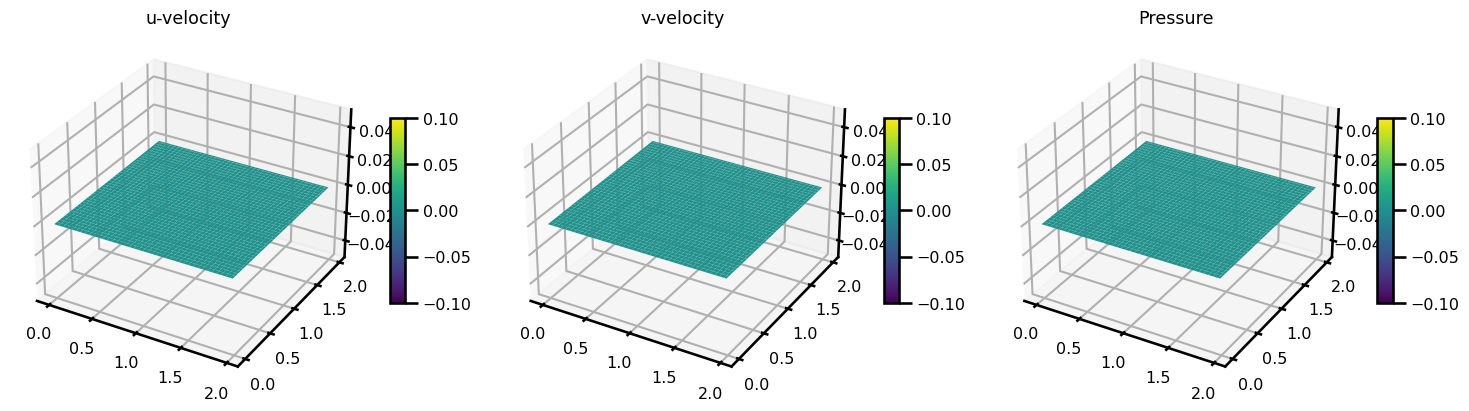

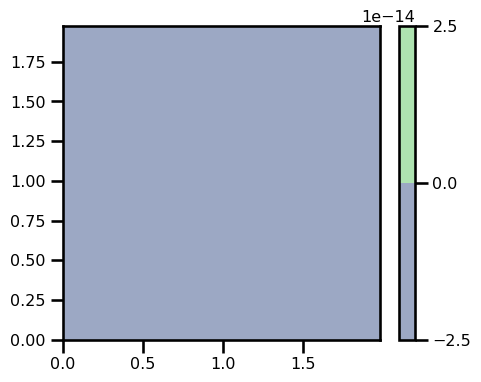

In [20]:
plot_state_2D(state_rhs, params)
plot_state_3D(state_rhs, params)
plot_vectorfield_2D(state_rhs, params)

#### Diffusion Term

Looking at the NS equation {eq}`eq:2d_ns`, we have the diffusion term for $u$ and $v$. Technically we have a diffusion term for pressure, $p$, but that's coupled to an elliptical equation so we won't count that.

$$
\begin{aligned}
\frac{\partial u}{\partial t} &= 
\nu \left(\frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2}\right) \\
\frac{\partial v}{\partial t} &= 
\nu \left(\frac{\partial^2 v}{\partial x^2} + \frac{\partial^2 v}{\partial y^2}\right) \\
\end{aligned}
$$

They recommend that we use the 2nd order accurate central difference scheme. We will make a generic diffusion term that should work for both $u$ and $v$.

$$
\text{Diffusion} :=  \nu\left(\frac{\partial^2 u(x,t)}{\partial x^2} + \frac{\partial^2 u(x,t)}{\partial y^2}\right)
$$

In [21]:
from jaxsw._src.operators.functional import advection, diffusion


def u_term(state, params):
    # parse state
    u, v = state.u, state.v

    # parse parameters
    domain, nu = params.domain, params.nu

    # # calculate boundaries
    # u = boundaries_u(u)
    # v = boundaries_v(v)

    # calculate advection term
    u_rhs_advection = advection.advection_2D(
        u=state_rhs.u,
        a=state_rhs.u,
        b=state_rhs.v,
        step_size=domain.dx,
        accuracy=1,
    )

    # calculate diffusion term
    u_rhs_diffusion = diffusion.diffusion_2D(u=u, diffusivity=nu, step_size=domain.dx)

    # calculate RHS
    u_rhs = -u_rhs_advection + u_rhs_diffusion
    return u_rhs


def v_term(state, params):
    # parse state
    u, v = state.u, state.v

    # parse parameters
    domain, nu = params.domain, params.nu

    # # calculate boundaries
    # u = boundaries_u(u)
    # v = boundaries_v(v)

    # calculate advection term
    v_rhs_advection = advection.advection_2D(
        u=state_rhs.v,
        a=state_rhs.u,
        b=state_rhs.v,
        step_size=domain.dx,
        accuracy=1,
    )

    # calculate diffusion term
    v_rhs_diffusion = diffusion.diffusion_2D(u=v, diffusivity=nu, step_size=domain.dx)

    # calculate RHS
    v_rhs = -v_rhs_advection + v_rhs_diffusion
    return v_rhs

In [22]:
from jaxsw._src.operators.functional import advection


# calculate P
p = p_term(state_init, params)
state_rhs = eqx.tree_at(lambda x: x.p, state_init, p)

# calculate RHS - U,V
u_rhs = u_term(state_rhs, params)
v_rhs = v_term(state_rhs, params)

# some checks
assert u_rhs.shape == state_init.u.shape == v_rhs.shape == state_init.v.shape
print(u_rhs.min(), u_rhs.max())

# update state
state_rhs = eqx.tree_at(lambda x: x.u, state_rhs, u_rhs)
state_rhs = eqx.tree_at(lambda x: x.v, state_rhs, v_rhs)

0.0 0.0


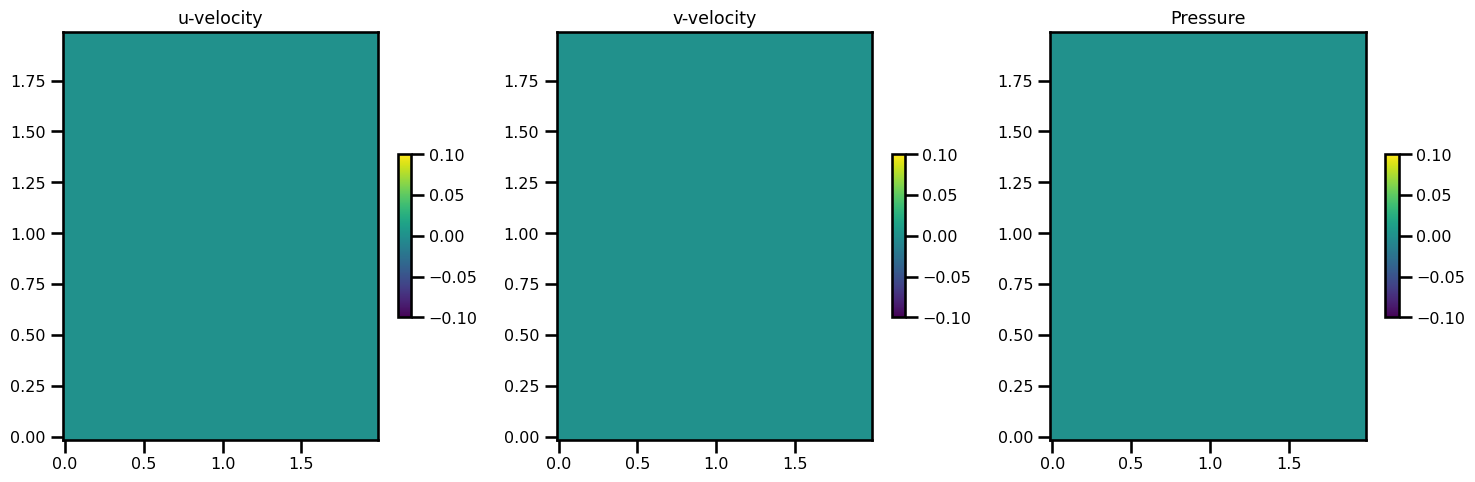

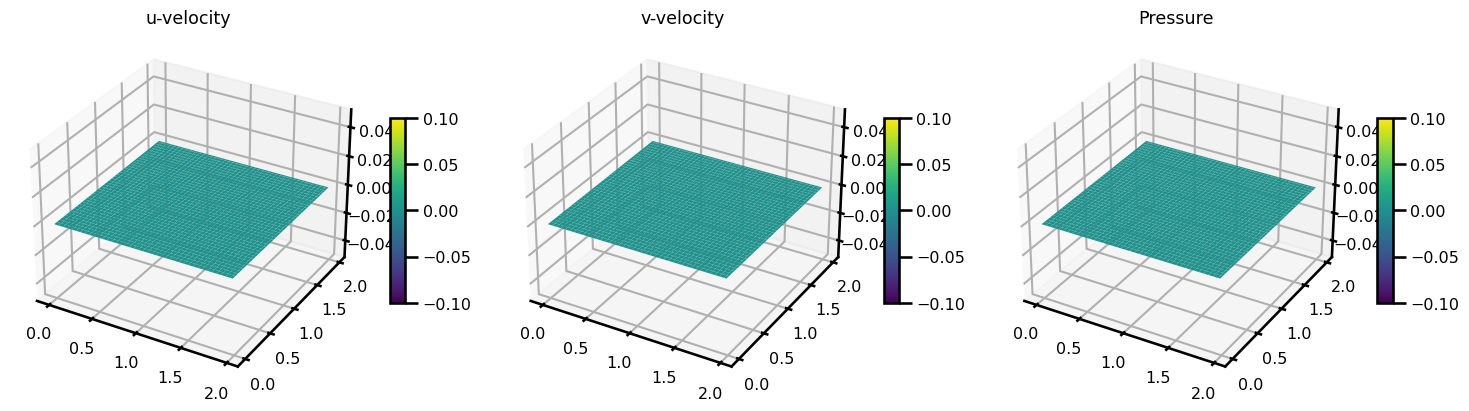

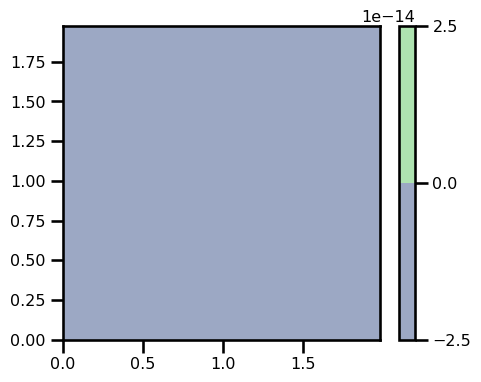

In [23]:
plot_state_2D(state_rhs, params)
plot_state_3D(state_rhs, params)
plot_vectorfield_2D(state_rhs, params)

### Linear Term

Looking at the NS equation {eq}`eq:2d_ns`, we can look at the u-velocity equation:

$$
\begin{aligned}
\frac{\partial u}{\partial t} &+ 
u\frac{\partial u}{\partial x} + v\frac{\partial u}{\partial y} = 
- \frac{1}{\rho}\frac{\partial p}{\partial x} +
\nu\left(\frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2}\right)
\end{aligned}
$$ (eq:2d_ns)

In [24]:
from jaxsw._src.operators.functional import advection, diffusion


def u_term(state, params):
    # parse state
    u, v, p = state.u, state.v, state.p

    # parse parameters
    domain, nu, rho = params.domain, params.nu, params.rho

    # # calculate boundaries
    # u = boundaries_u(u)
    # v = boundaries_v(v)
    # p = boundaries_p(p)

    # calculate advection term
    u_rhs_advection = -advection.advection_2D(
        u=state_rhs.u,
        a=state_rhs.u,
        b=state_rhs.v,
        step_size=domain.dx,
        accuracy=1,
    )

    # calculate diffusion term
    u_rhs_diffusion = diffusion.diffusion_2D(u=u, diffusivity=nu, step_size=domain.dx)

    # linear term
    u_rhs_linear = -(1 / rho) * fdx.difference(
        p,
        axis=0,
        step_size=domain.dx[0],
        derivative=1,
        accuracy=1,
        method="central",
    )

    # calculate RHS
    u_rhs = u_rhs_advection + u_rhs_diffusion + u_rhs_linear

    u_rhs = jnp.where(jnp.isnan(u_rhs), 0.0, u_rhs)

    return u_rhs


def v_term(state, params):
    # parse state
    u, v, p = state.u, state.v, state.p

    # parse parameters
    domain, nu = params.domain, params.nu

    # calculate boundaries
    u = boundaries_u(u)
    v = boundaries_v(v)
    p = boundaries_p(p)

    # calculate advection term
    v_rhs_advection = -advection.advection_2D(
        u=state_rhs.v,
        a=state_rhs.u,
        b=state_rhs.v,
        step_size=domain.dx,
        accuracy=1,
    )

    # calculate diffusion term
    v_rhs_diffusion = diffusion.diffusion_2D(u=v, diffusivity=nu, step_size=domain.dx)

    # linear term
    v_rhs_linear = -(1 / rho) * fdx.difference(
        p,
        axis=0,
        step_size=domain.dx[0],
        derivative=1,
        accuracy=1,
        method="central",
    )

    # calculate RHS
    v_rhs = v_rhs_advection + v_rhs_diffusion + v_rhs_linear

    v_rhs = jnp.where(jnp.isnan(v_rhs), 0.0, v_rhs)

    return v_rhs

In [25]:
from jaxsw._src.operators.functional import advection


# calculate boundaries
# update state
state_rhs = eqx.tree_at(lambda x: x.u, state_init, boundaries_u(state_init.u))
state_rhs = eqx.tree_at(lambda x: x.v, state_rhs, boundaries_u(state_rhs.v))

# calculate P
p = p_term(state_rhs, params)
state_rhs = eqx.tree_at(lambda x: x.p, state_rhs, p)

# calculate RHS - U,V
u_rhs = u_term(state_rhs, params)
v_rhs = v_term(state_rhs, params)

# some checks
assert u_rhs.shape == state_init.u.shape == v_rhs.shape == state_init.v.shape
print(u_rhs.min(), u_rhs.max())

# update state
state_rhs = eqx.tree_at(lambda x: x.u, state_rhs, u_rhs)
state_rhs = eqx.tree_at(lambda x: x.v, state_rhs, v_rhs)

0.0 160.0


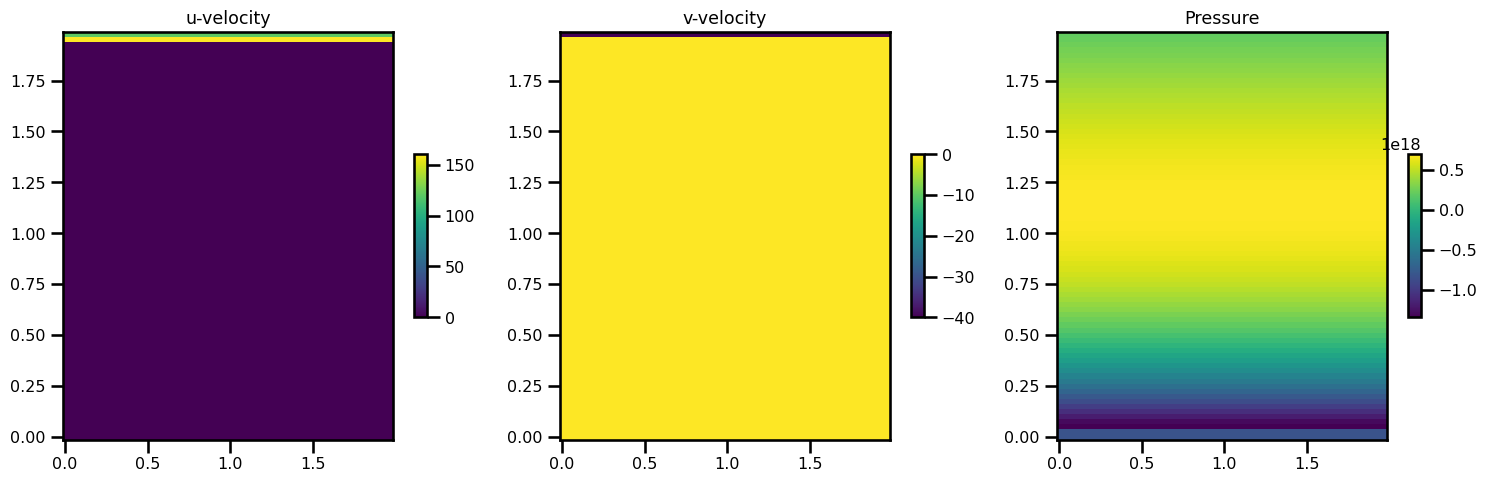

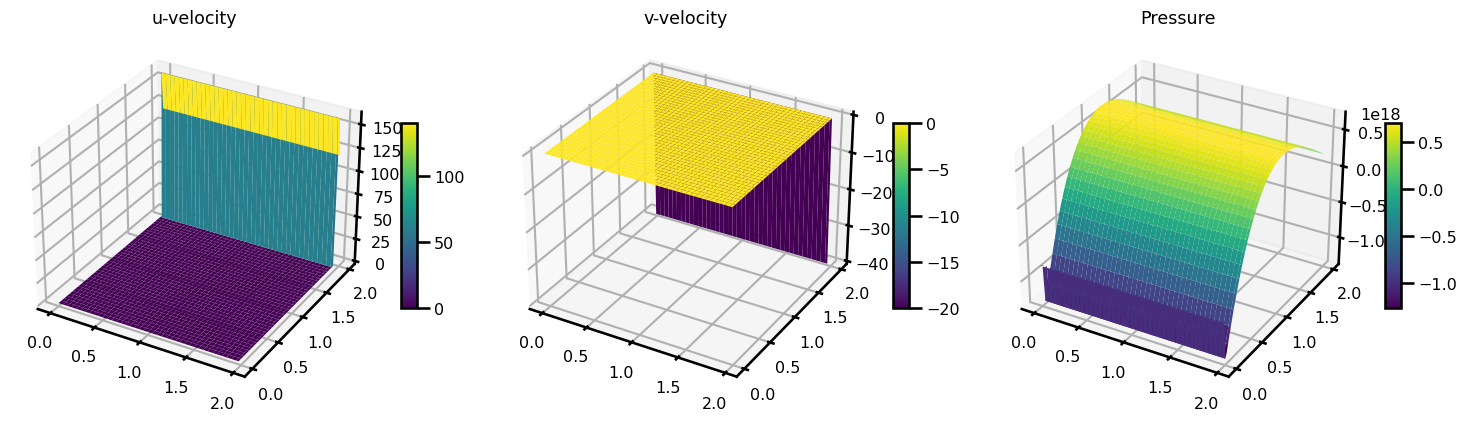

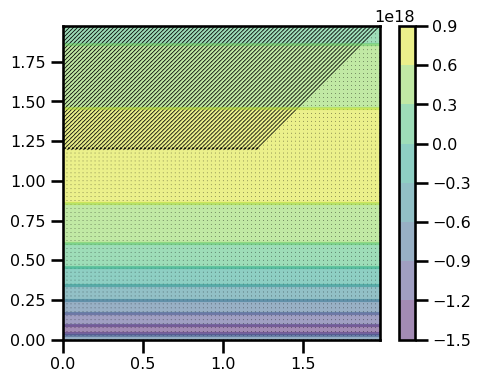

In [26]:
plot_state_2D(state_rhs, params)
plot_state_3D(state_rhs, params)
plot_vectorfield_2D(state_rhs, params)

### Equation of Motion

In [27]:
"""Generic 2D Diffusion Term
Advection:
    ∂u/∂t = a ∂u/∂x + b ∂u/∂y

Diffusion:
    ∂u/∂t = ν (∂²u/∂x² + ∂²u/∂y²)
   
\nVelocity Product:
    ∂u/∂t =  -ρ(∂u/∂x ∂u/∂x + ∂u/∂y ∂v/∂x + ∂v/∂y ∂v/∂y)
    
Inversion Term:
    Ax = b
    Δu = f

"""

'Generic 2D Diffusion Term\nAdvection:\n    ∂u/∂t = a ∂u/∂x + b ∂u/∂y\n\nDiffusion:\n    ∂u/∂t = ν (∂²u/∂x² + ∂²u/∂y²)\n   \n\nVelocity Product:\n    ∂u/∂t =  -ρ(∂u/∂x ∂u/∂x + ∂u/∂y ∂v/∂x + ∂v/∂y ∂v/∂y)\n    \nInversion Term:\n    Ax = b\n    Δu = f\n\n'

In [28]:
class NavierStokes2D(DynamicalSystem):
    @staticmethod
    def equation_of_motion(t: float, state: State, args):
        """2D Navier-Stokes Equation

        Equation:
            ∂u/∂t + u ∂u/∂x + v ∂u/∂y = -ρ ∂p/∂x + ν (∂²u/∂x² + ∂²u/∂y²)
            ∂v/∂t + u ∂v/∂x + v ∂v/∂y = -ρ ∂p/∂y + ν (∂²v/∂x² + ∂²v/∂y²)
            ∂²p/∂x² + ∂²p/∂y² = -ρ(∂u/∂x ∂u/∂x + ∂u/∂y ∂v/∂x + ∂v/∂y ∂v/∂y)
        """

        params = args

        state = eqx.tree_at(lambda x: x.u, state, boundaries_u(state.u))
        state = eqx.tree_at(lambda x: x.v, state, boundaries_v(state.v))

        # calculate P
        p = p_term(state, params)
        state_rhs = eqx.tree_at(lambda x: x.p, state, p)

        # calculate RHS - U,V
        u_rhs = u_term(state_rhs, params)
        v_rhs = v_term(state_rhs, params)

        # update state
        state_rhs = eqx.tree_at(lambda x: x.u, state_rhs, u_rhs)
        state_rhs = eqx.tree_at(lambda x: x.v, state_rhs, v_rhs)

        return state_rhs

In [29]:
# SPATIAL DISCRETIZATION
# initialize state
state_init = State.init_state(domain, init_fn=init_u0)
params = Params(domain=domain, nu=nu, rho=rho)

# right hand side
state_out = NavierStokes2D.equation_of_motion(0, state_init, params)

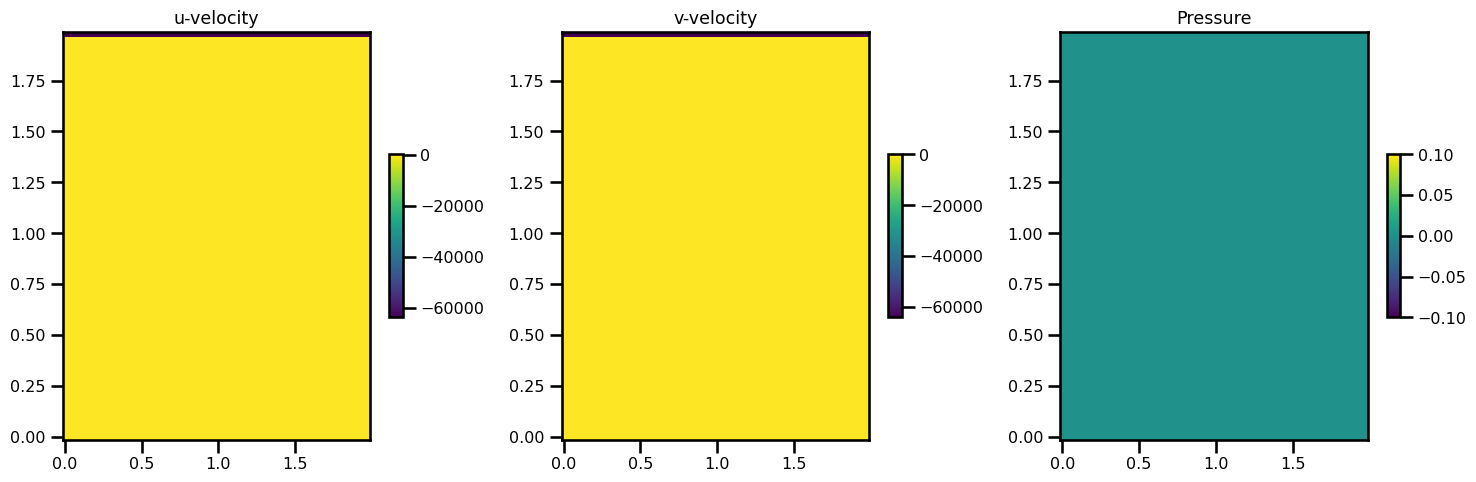

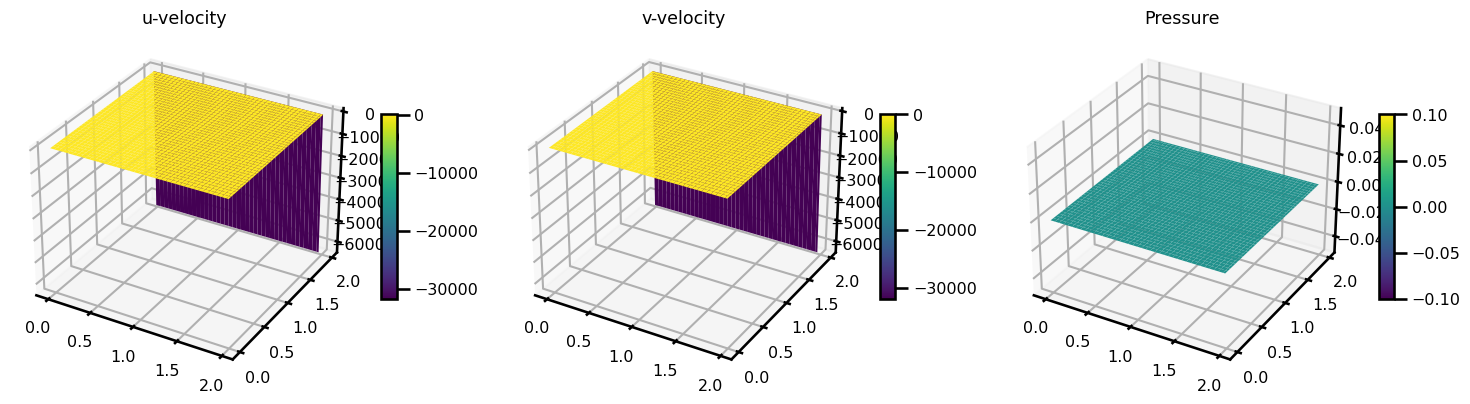

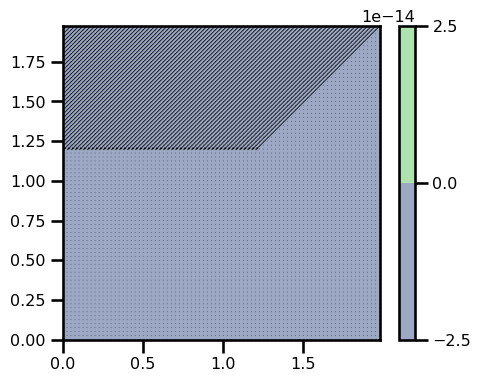

In [30]:
plot_state_2D(state_out, params)
plot_state_3D(state_out, params)
plot_vectorfield_2D(state_out, params)

## Time Stepping

Here we use the Euler method with a constant stepsize.

#### CFD Condition

In [31]:
# TEMPORAL DISCRETIZATION
# initialize temporal domain

sigma = 0.0009
nu = 0.1
rho = 1.0
dt = 0.001  # sigma * domain.dx[0] * domain.dx[1] / nu
print(f"Step Size (dt): {dt:.4e}")

tmin = 0.0
tmax = 0.005  # (np.arange(120) * dt).max()
num_save = 20

Step Size (dt): 1.0000e-03


In [32]:
t_domain = TimeDomain(tmin=tmin, tmax=tmax, dt=dt)
ts = jnp.linspace(tmin, tmax, num_save)
saveat = dfx.SaveAt(ts=ts)

# DYNAMICAL SYSTEM
dyn_model = NavierStokes2D(t_domain=t_domain, saveat=saveat)

### Integration

In [33]:
# Euler, Constant StepSize
solver = dfx.Euler()
stepsize_controller = dfx.ConstantStepSize()

# SPATIAL DISCRETIZATION
state_init = State.init_state(domain, init_u0)
params_init = Params(domain=domain, nu=nu, rho=rho)


# integration
sol = dfx.diffeqsolve(
    terms=dfx.ODETerm(dyn_model.equation_of_motion),
    solver=solver,
    t0=ts.min(),
    t1=ts.max(),
    dt0=dt,
    y0=state_init,
    saveat=saveat,
    args=params_init,
    stepsize_controller=stepsize_controller,
)

## Analysis

In [34]:
da_sol = xr.Dataset(
    data_vars={
        "u": (("time", "x", "y"), np.asarray(sol.ys.u)),
        "v": (("time", "x", "y"), np.asarray(sol.ys.v)),
        "p": (("time", "x", "y"), np.asarray(sol.ys.p)),
    },
    coords={
        "x": (["x"], np.asarray(domain.coords[0])),
        "y": (["y"], np.asarray(domain.coords[1])),
        "time": (["time"], np.asarray(sol.ts)),
    },
    attrs={"pde": "navier_stokes_cavity", "sigma": sigma},
)
da_sol

<xarray.Dataset>
Dimensions:  (time: 20, x: 80, y: 80)
Coordinates:
  * x        (x) float64 0.0 0.025 0.05 0.075 0.1 ... 1.875 1.9 1.925 1.95 1.975
  * y        (y) float64 0.0 0.025 0.05 0.075 0.1 ... 1.875 1.9 1.925 1.95 1.975
  * time     (time) float64 0.0 0.0002632 0.0005263 ... 0.004474 0.004737 0.005
Data variables:
    u        (time, x, y) float64 0.0 0.0 0.0 ... -8.454e+75 5.879e+74
    v        (time, x, y) float64 0.0 0.0 0.0 0.0 ... 3.105e+73 1.335e+74 -320.0
    p        (time, x, y) float64 0.0 0.0 0.0 ... -4.322e+154 -1.045e+155 0.0
Attributes:
    pde:      navier_stokes_cavity
    sigma:    0.0009

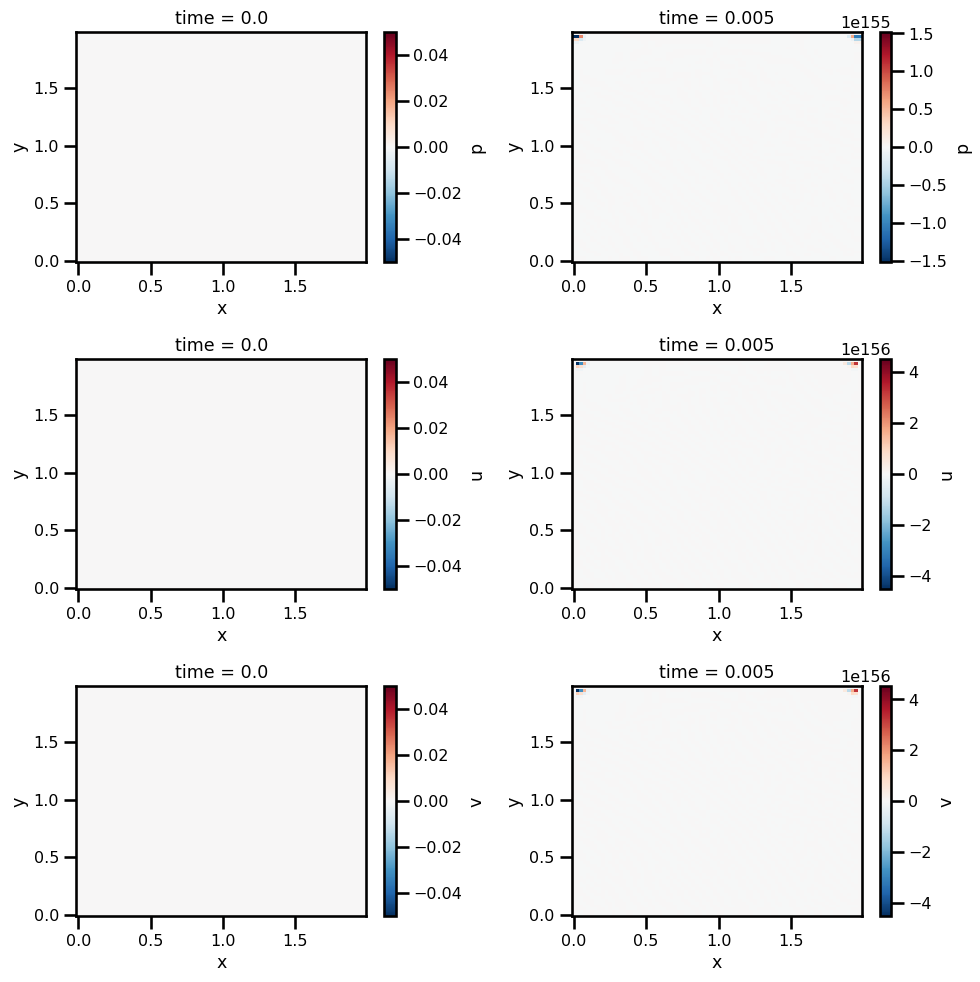

In [35]:
fig, ax = plt.subplots(ncols=2, nrows=3, figsize=(10, 10))
t1 = -1
# P
da_sol.p.isel(time=0).T.plot.pcolormesh(ax=ax[0, 0], cmap="RdBu_r")
da_sol.p.isel(time=t1).T.plot.pcolormesh(ax=ax[0, 1], cmap="RdBu_r")

# U
da_sol.u.isel(time=0).T.plot.pcolormesh(ax=ax[1, 0], cmap="RdBu_r")
da_sol.u.isel(time=t1).T.plot.pcolormesh(ax=ax[1, 1], cmap="RdBu_r")

# V
da_sol.v.isel(time=0).T.plot.pcolormesh(ax=ax[2, 0], cmap="RdBu_r")
da_sol.v.isel(time=t1).T.plot.pcolormesh(ax=ax[2, 1], cmap="RdBu_r")

plt.tight_layout()
plt.show()

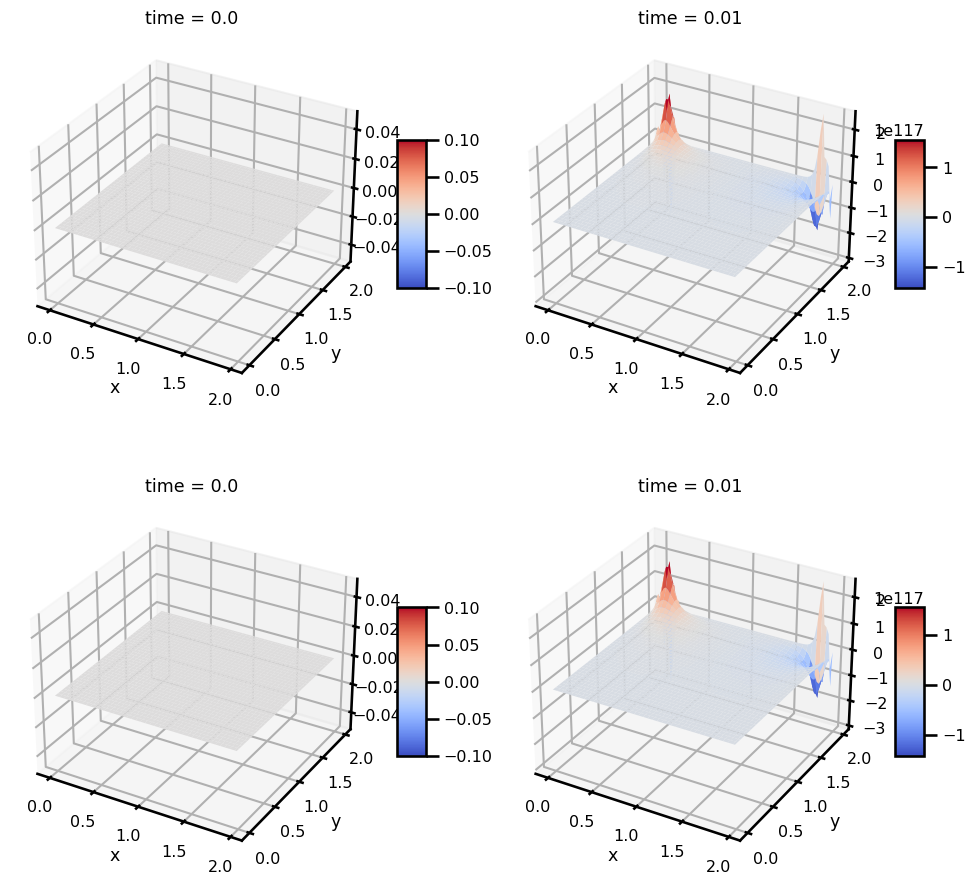

In [107]:
fig, ax = plt.subplots(
    ncols=2, nrows=2, subplot_kw={"projection": "3d"}, figsize=(10, 10)
)

vmin = da_sol.min()
vmax = da_sol.max()

cbar_kwargs = dict(shrink=0.3, aspect=5)

# U
vmin = None  # da_sol.u.min()
vmax = None  # da_sol.u.max()

pts = da_sol.u.isel(time=0).T.plot.surface(
    ax=ax[0, 0], vmin=vmin, vmax=vmax, cmap="coolwarm", add_colorbar=False
)
plt.colorbar(pts, **cbar_kwargs)
pts = da_sol.u.isel(time=-1).T.plot.surface(
    ax=ax[0, 1], vmin=vmin, vmax=vmax, cmap="coolwarm", add_colorbar=False
)
plt.colorbar(pts, **cbar_kwargs)

# V
vmin = None  # da_sol.v.min()
vmax = None  # da_sol.v.max()
pts = da_sol.v.isel(time=0).T.plot.surface(
    ax=ax[1, 0], vmin=vmin, vmax=vmax, cmap="coolwarm", add_colorbar=False
)
plt.colorbar(pts, **cbar_kwargs)
pts = da_sol.v.isel(time=-1).T.plot.surface(
    ax=ax[1, 1], vmin=vmin, vmax=vmax, cmap="coolwarm", add_colorbar=False
)
plt.colorbar(pts, **cbar_kwargs)
plt.tight_layout()
plt.show()

In [ ]:
# SPATIAL DISCRETIZATION
state_init = State.init_state(domain, nu=nu, rho=rho, init_fn=init_u0)

In [95]:
state_sol.u[-1].min(), state_sol.u[-1].min()

(Array(-2.61741034e+24, dtype=float64), Array(-2.61741034e+24, dtype=float64))

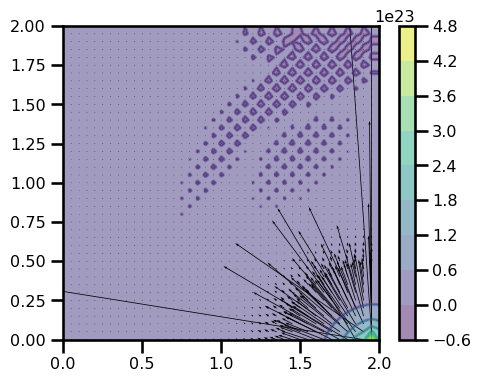

In [96]:
plot_vectorfield_2D(state_sol, axis=-1)

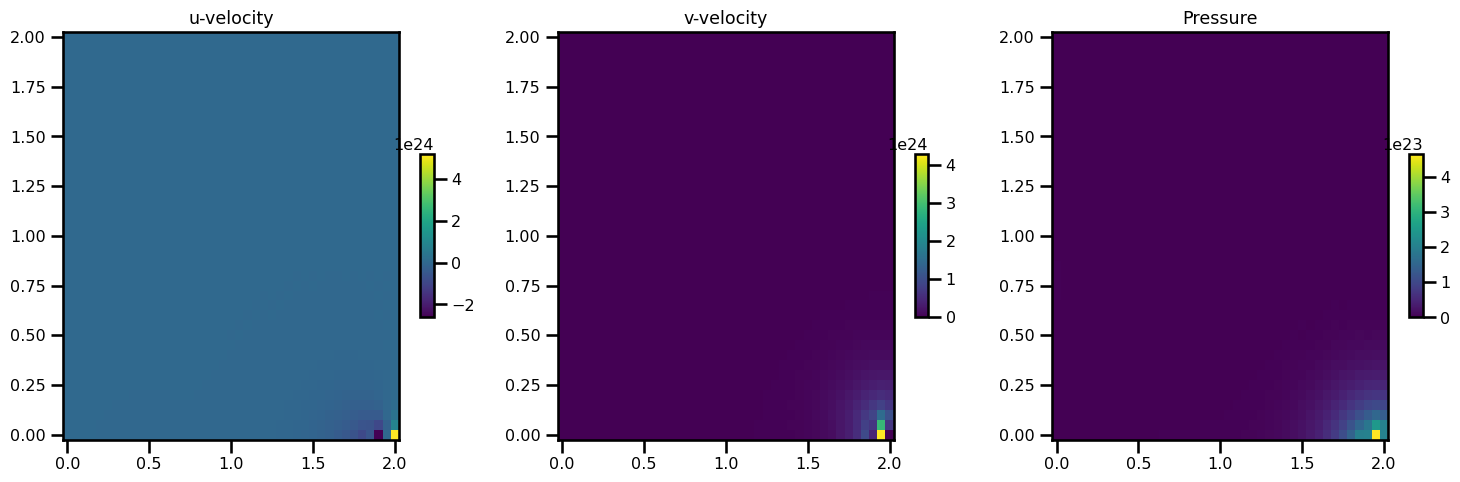

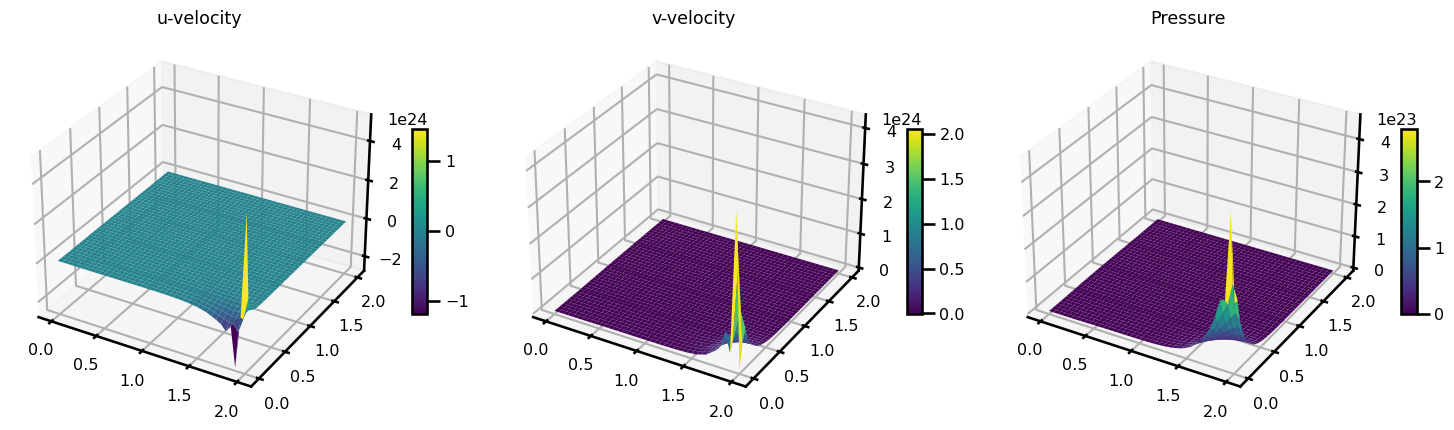

In [97]:
plot_state_2D(state_sol, axis=-1)
plot_state_3D(state_sol, axis=-1)